In [1]:
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import cv2
import os
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
from Utils import *
from open3d.web_visualizer import draw
from VisulizerTools import *
from DDBSCAN import Raster_DBSCAN
import threading
import dpkt
import time
import matplotlib.animation as animation
plt.rcParams["font.family"] = "Times New Roman"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [66]:
packets = []
with open(pcap_path, 'rb') as fpcap:
    lidar_reader = dpkt.pcap.Reader(fpcap)
    while True:
        ts,buf = next(lidar_reader)
        eth = dpkt.ethernet.Ethernet(buf)
        if eth.type == 2048:
            if type(eth.data.data) == dpkt.udp.UDP:
                data = eth.data.data.data
                packet_status = eth.data.data.sport
                packets.append(data)

StopIteration: 

In [70]:
eth.data.data.data = packets[0]

In [78]:
a = dpkt.ethernet.Ethernet()
a.dst = 121
a.src = 131
a.data = packets[0]

In [38]:
with open(pcap_path, 'rb') as fpcap:
    lidar_reader = dpkt.pcap.Reader(fpcap)
    ts,buf = next(lidar_reader)
    eth = dpkt.ethernet.Ethernet(buf)

In [4]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\ASWS\Thomas\2022-04-06-15-11-07.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)

 16%|████████████▏                                                                | 2856/18000 [01:44<09:15, 27.25it/s]


AttributeError: 'ICMP' object has no attribute 'sport'

In [62]:
a = time.time()
thred_map = gen_bckmap(aggregated_map)
time.time() - a

100%|██████████████████████████████████████████████████████████████████████████| 57600/57600 [00:13<00:00, 4284.88it/s]


13.443619966506958

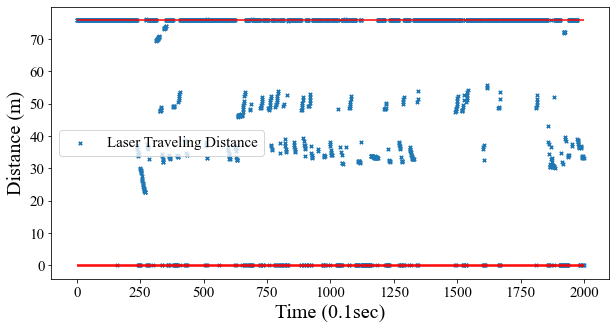

In [31]:
laser_id = 14
azimuth_channel = 51
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
bck_ds = thred_map[:,laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 12, marker = 'x', label = "Laser Traveling Distance")
for b in bck_ds:
    plt.hlines(b,0,2000, color = 'r')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)

# plt.ylim(17.5,19)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\Picture5.tif', dpi = 600)
plt.show()

In [47]:
db = Raster_DBSCAN(window_size=[7,11],eps = 1.1,min_samples= 5,Td_map_szie=(32,1800))

In [33]:
Td_map = aggregated_map[370].copy()
Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.3).any(axis = 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
pcd = get_pcd_colored_specified(Td_map,Labeling_map,[6])
draw(pcd,width=1000,height=1000)

WebVisualizer(window_uid='window_18')

In [157]:
Td_map_next = aggregated_map[1].copy()
Labeling_map_next = show_result(Td_map_next)

WebVisualizer(window_uid='window_26')

In [197]:
pcd = get_pcd_colored_specified(Td_map_next,Labeling_map_next,np.arange(8,9))
draw(pcd,width=1000,height=1000)

WebVisualizer(window_uid='window_29')

In [110]:
xy_set,apperance_set,new_uni_labels,Labeling_map = extract_xy(Labeling_map_next,Td_map_next)
pcd = get_pcd_colored_specified(Td_map_next,Labeling_map_next,[6])
points = np.asarray(pcd.points)

In [77]:
test_traj = []

In [112]:
test_traj.append(xy_set[new_uni_labels == 8])

In [114]:
test_traj = np.array(test_traj)

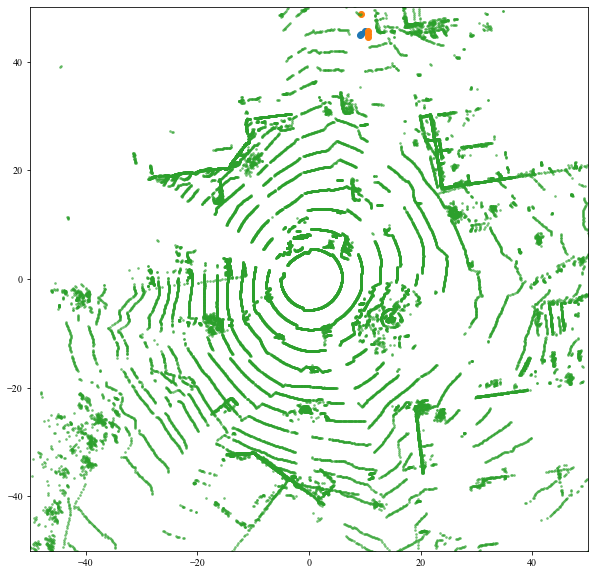

In [199]:
plt.figure(figsize=(10,10))
plt.scatter(test_traj[:,0,0,:,0][:,0],test_traj[:,0,0,:,0][:,1])
plt.scatter(test_traj[:,0,1,:,0][:,0],test_traj[:,0,1,:,0][:,1])
plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.5)
plt.ylim(-50,50)
plt.xlim(-50,50)
plt.show()

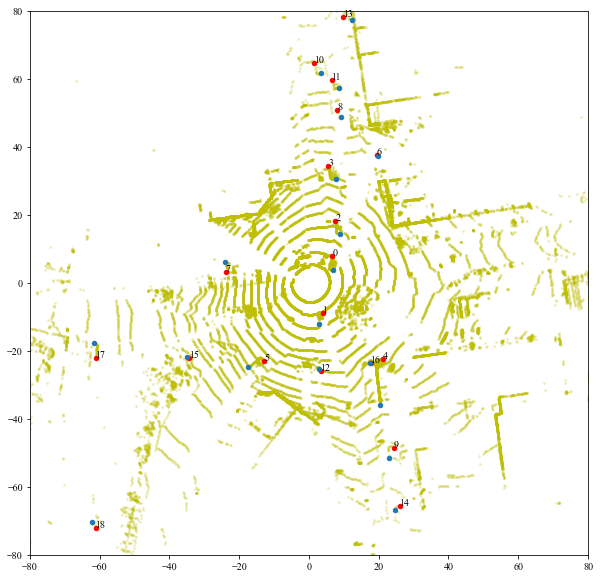

In [213]:
plt.figure(figsize=(10,10))
plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.2, c = 'y')
plt.scatter(xy_set[:,0,:,0][:,0],xy_set[:,0,:,0][:,1],s = 20,c = 'r')
plt.scatter(xy_set[:,1,:,0][:,0],xy_set[:,1,:,0][:,1],s = 20)
for i in range(xy_set.shape[0]):
    plt.annotate(i,xy_set[:,0,:,0][i])
plt.ylim(-80,80)
plt.xlim(-80,80)
plt.show()

In [94]:
with open(r'D:\Test\test_kal_td.pickle', 'rb') as handle:
    Off_tracking_pool = pickle.load(handle)

In [95]:
lengths = np.array([len(Off_tracking_pool[key].post_seq) for key in Off_tracking_pool.keys()])
keys = np.array([key for key in Off_tracking_pool.keys()])

In [97]:
app_col_names = ['Point_Cnt','Dir_X_Bbox','Dir_Y_Bbox','Height','Length','Width','Area','Dis']
column_names_TR_2o = ['ObjectID','FrameIndex','Coord_X','Coord_Y','Coord_Z','Speed_X','Speed_Y','Speed','Longitude','Latitude','Elevation']


In [98]:
def get_summary_file_TR(post_seq,key,start_frame,app_seq,P_seq,T,missing_thred):
    temp = np.array(post_seq)
    temp = temp[:-missing_thred]
    temp = temp.reshape((temp.shape[0],temp.shape[1],temp.shape[2]))
    # n x 2 x 6
    temp_xy = temp[:,:,:2]
    # n x 2 x 2
#     dis_est = np.sqrt((temp_xy[:,:,0]**2 + temp_xy[:,:,1]**2))
    # n x 2 
    speed_xy = temp[:,:,2:4] * 10 
    # n x 2 x 2
    speed = np.sqrt((speed_xy[:,:,0]**2 + speed_xy[:,:,1]**2))
    # n x 2
    xyz_0 = np.concatenate([temp_xy[:,0],np.zeros(len(temp_xy)).reshape(-1,1)],axis = 1)
    xyz_1 = np.concatenate([temp_xy[:,1],np.zeros(len(temp_xy)).reshape(-1,1)],axis = 1)
    xyz = (xyz_0 + xyz_1)/2
    LLH_est = convert_LLH(xyz,T)
    est = np.concatenate([xyz_0,speed_xy[:,0],speed[:,0].reshape(-1,1),LLH_est],axis = 1)
    # x,y,z,d,s_x,s_y,s,L,L,H
    timestp = []
    for i in range(len(temp)):
        f = i + start_frame + 1
        timestp.append('%06.0f'%f)
    timestp = np.array(timestp).reshape(-1,1)
    objid = (np.ones(len(temp)) * key).astype(int).reshape(-1,1)
    summary = np.concatenate([objid,timestp,est],axis = 1)
    # obj_id,ts,x,y,z,d,s_x,s_y,s,L,L,H
    summary = pd.DataFrame(summary,columns = column_names_TR_2o)
    app_seq = np.array(app_seq)[:-missing_thred]
    app_seq = app_seq.reshape(-1,len(app_col_names))

    app_df = pd.DataFrame(app_seq,columns = app_col_names)

    max_length = np.percentile(np.array(app_df.Length), 80)
    app_df['Max_Length'] = max_length

    return summary,app_df

In [117]:
ref_LLH,ref_xyz = pd.read_csv(r'D:\LiDAR_Data\ASWS\Thomas\Calibration\LLE_ref.csv'),pd.read_csv(r'D:\LiDAR_Data\ASWS\Thomas\Calibration\xyz_ref.csv')
ref_LLH,ref_xyz = np.array(ref_LLH),np.array(ref_xyz)
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808
T = generate_T(ref_LLH,ref_xyz)

In [118]:
def save_result(Off_tracking_pool,ref_LLH,ref_xyz,f_path,missing_thred):

    if len(Off_tracking_pool) == 0:
        print('No Trajs Here')
    else:
        # print('Generating Traj Files...')
        T = generate_T(ref_LLH,ref_xyz)
        sums = []
        app_dfs = []
        keys = []
        start_frame = []
        lengths = []
        for key in Off_tracking_pool: 
            if len(Off_tracking_pool[key].post_seq) < (10 + missing_thred):
                continue
            sum_file,app_df = get_summary_file_TR(Off_tracking_pool[key].post_seq,
                                        key,Off_tracking_pool[key].start_frame,Off_tracking_pool[key].app_seq,Off_tracking_pool[key].P_seq,T,missing_thred) 
            sums.append(sum_file)
            app_dfs.append(app_df)
            keys.append(key)
            start_frame.append(Off_tracking_pool[key].start_frame)   
            lengths.append(len(sum_file))   

        sums = pd.concat(sums)
        app_dfs = pd.concat(app_dfs)
        sums = sums.reset_index(drop=True).astype('float64')
        app_dfs = app_dfs.reset_index(drop=True).astype('float64')

        classifier = pickle.load(open('./Classifier/Classifier.sav', 'rb'))
        X_test = np.array(app_dfs.loc[:,['Point_Cnt','Height','Max_Length','Area']])
        pred = classifier.predict(X_test)
        sums = pd.concat([sums,app_dfs,pd.DataFrame(pred.reshape(-1,1),columns=['Class'])],axis = 1)
        sums.to_csv(f_path,index = False)

In [119]:
save_result(Off_tracking_pool,ref_LLH,ref_xyz,r'D:\Test\test.csv',10)

In [120]:
data = pd.read_csv(r'D:\Test\test.csv') # path to result

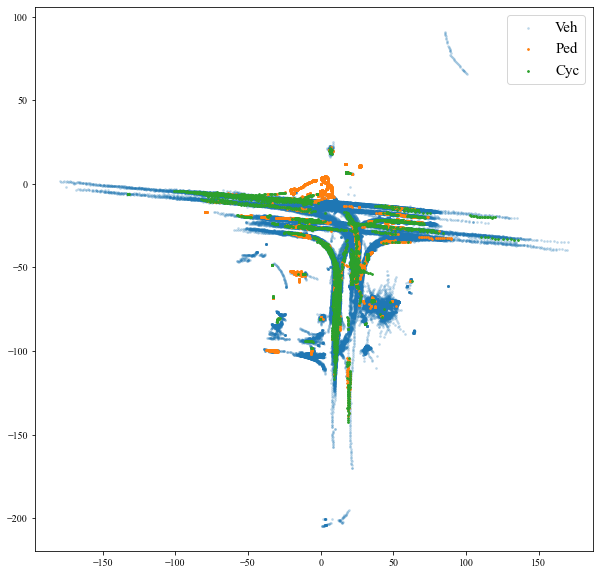

In [121]:
# data = pd.read_csv(r'D:\Test\test.csv') # path to result
plt.figure(figsize=(10,10))
plt.scatter(data.loc[data.Class == 1,'Coord_X'],data.loc[data.Class == 1,'Coord_Y'], s = 3, alpha = 0.2,label = 'Veh')
plt.scatter(data.loc[data.Class == 2,'Coord_X'],data.loc[data.Class == 2,'Coord_Y'], s = 3, label = 'Ped')
plt.scatter(data.loc[data.Class == 3,'Coord_X'],data.loc[data.Class == 3,'Coord_Y'], s = 3,label = 'Cyc')
# plt.xlim(-80,80)
# plt.ylim(-80,80)
plt.legend(fontsize = 15)
plt.show()

NameError: name 'points' is not defined

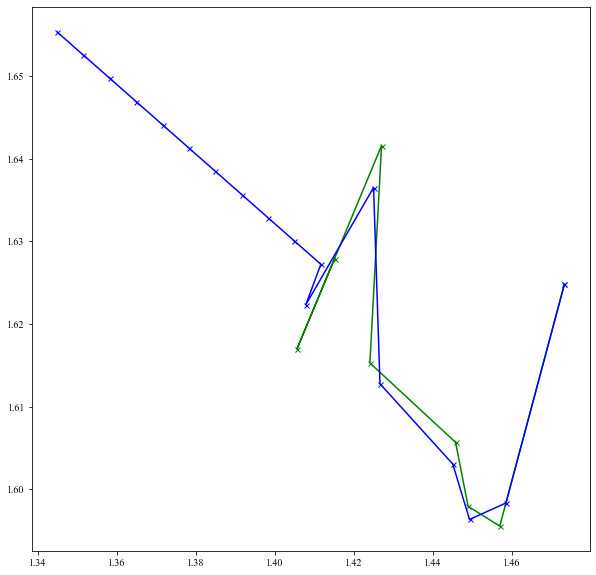

In [108]:
key = 0
plt.figure(figsize=(10,10))
mea_seq = Off_tracking_pool[key].mea_seq
meas = []
for i in range(len(mea_seq)):
    if type(mea_seq[i]) == int:
        continue
    else:
        meas.append(mea_seq[i])
meas = np.array(meas)
post_seq =  np.array(Off_tracking_pool[key].post_seq)
P_seq = np.array(Off_tracking_pool[key].P_seq)
app_seq = np.array(Off_tracking_pool[key].app_seq)
plt.plot(meas[:,0,0,0],meas[:,0,1,0], marker = 'x', markersize = 5,c = 'g' )
plt.plot(post_seq[:,0,0,0],post_seq[:,0,1,0], marker = 'x', markersize = 5,c = 'b')
plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.5 , c = 'r')
# plt.savefig(r'D:\Test\TrajFigs\{}.png'.format(key))
plt.show()
plt.figure(figsize=(10,10))
plt.plot(P_seq[:,0,0,0])
# plt.ylim(0,2.5)
plt.show()

In [255]:
group_iter = data.groupby('ObjectID')
trajs = []
for i,g in group_iter:
    if len(g) < 10:
        continue
    votes = []
    for c in range(1,4):
        temp = test_traj.loc[test_traj.Class == c]
        votes.append(len(temp))
    g.Class = np.argmax(c) + 1
    trajs.append(g)
post_data = pd.concat(trajs)

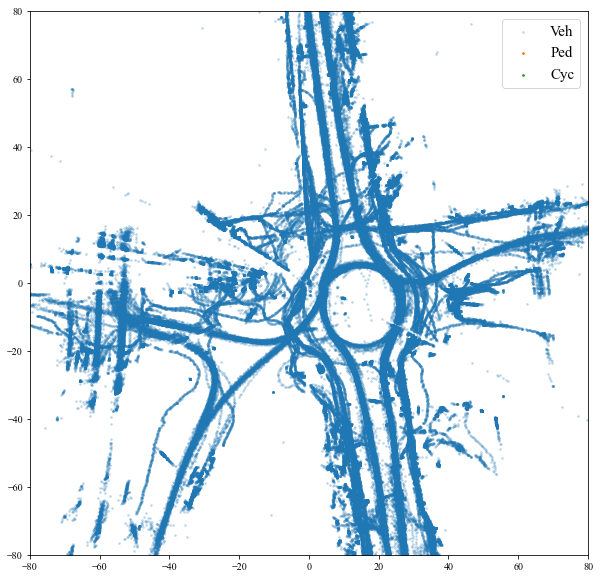

In [256]:
# post_data = pd.read_csv(r'D:\Test\test.csv') # path to result
plt.figure(figsize=(10,10))
plt.scatter(post_data.loc[post_data.Class == 1,'Coord_X'],post_data.loc[post_data.Class == 1,'Coord_Y'], s = 3, alpha = 0.2,label = 'Veh')
plt.scatter(post_data.loc[post_data.Class == 2,'Coord_X'],post_data.loc[post_data.Class == 2,'Coord_Y'], s = 3, label = 'Ped')
plt.scatter(post_data.loc[post_data.Class == 3,'Coord_X'],post_data.loc[post_data.Class == 3,'Coord_Y'], s = 3,label = 'Cyc')
plt.xlim(-80,80)
plt.ylim(-80,80)
plt.legend(fontsize = 15)
plt.show()

## Analysis tool

In [17]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Roundabout\2022-1-19-14-30-0.pcap'
end_frame = 200
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.38it/s]


In [18]:
with open(r'D:\Test\test_kal_td.pickle', 'rb') as handle:
    Off_tracking_pool = pickle.load(handle)

In [110]:
valid_keys = []
for key in Off_tracking_pool.keys():
    length = len(Off_tracking_pool[key].mea_seq)
    post_seq = Off_tracking_pool[key].post_seq
    dis = np.mean(np.sqrt(np.sum(((post_seq[0] - post_seq[-1])**2)[:,:2],axis = 1)))
    if (dis > 5) & (length > 10):
        valid_keys.append(key)

In [111]:
key = valid_keys[103]
mea_seq = Off_tracking_pool[key].mea_seq
meas = []
for i in range(len(mea_seq)):
    if type(mea_seq[i]) == int:
        continue
    else:
        meas.append(mea_seq[i])
meas = np.array(meas)
post_seq =  np.array(Off_tracking_pool[key].post_seq)
app_seq = np.array(Off_tracking_pool[key].app_seq)
print(Off_tracking_pool[key].start_frame)
print(Off_tracking_pool[key].start_frame + len(post_seq))

265
278


In [112]:
pcd = get_pcd_colored(aggregated_map[0],np.ones_like(aggregated_map[0]))
points = np.asarray(pcd.points)

KeyboardInterrupt: 

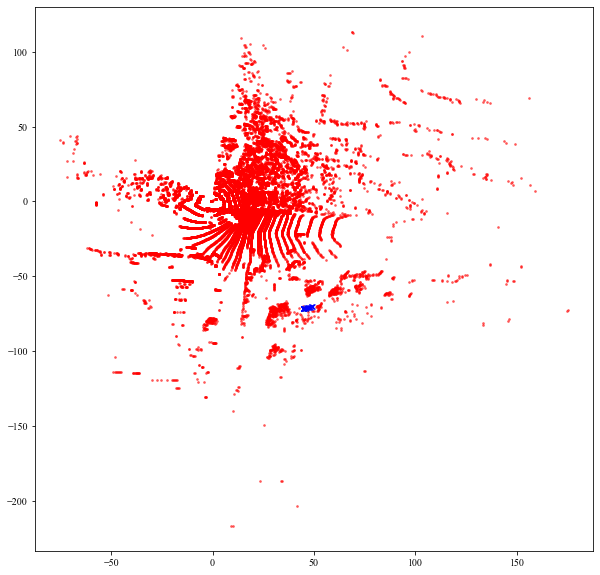

In [114]:
for key in valid_keys:
    plt.figure(figsize=(10,10))
    mea_seq = Off_tracking_pool[key].mea_seq
    meas = []
    for i in range(len(mea_seq)):
        if type(mea_seq[i]) == int:
            continue
        else:
            meas.append(mea_seq[i])
    meas = np.array(meas)
    post_seq =  np.array(Off_tracking_pool[key].post_seq)
    plt.plot(meas[:,0,0,0],meas[:,0,1,0], marker = 'x', markersize = 5,c = 'g' )
    plt.plot(post_seq[:,0,0,0],post_seq[:,0,1,0], marker = 'x', markersize = 5,c = 'b')
    plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.5 , c = 'r')
    plt.savefig(r'D:\Test\TrajFigs\{}.png'.format(key))
    plt.close()
#     plt.show()

In [45]:
np.set_printoptions(suppress=True)

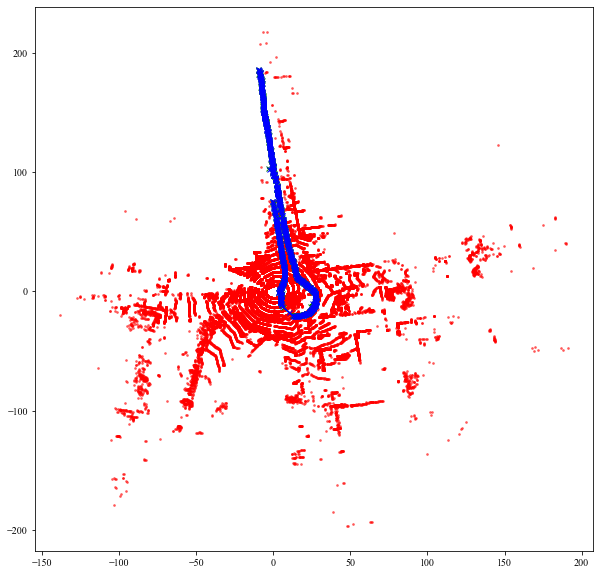

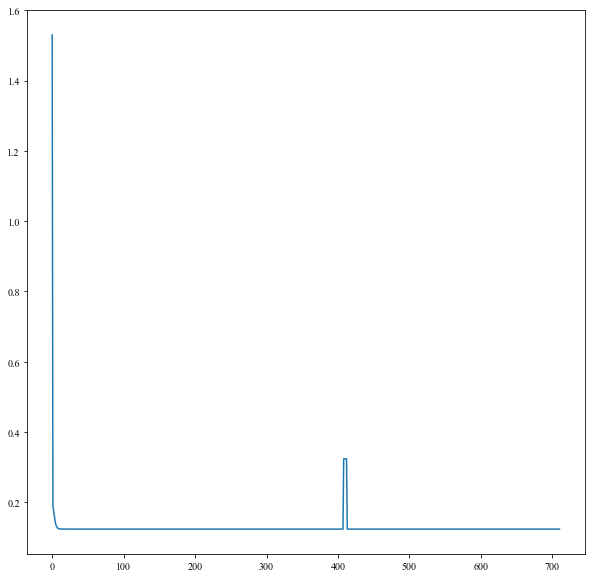

In [43]:
key = 2353
plt.figure(figsize=(10,10))
mea_seq = Off_tracking_pool[key].mea_seq
meas = []
for i in range(len(mea_seq)):
    if type(mea_seq[i]) == int:
        continue
    else:
        meas.append(mea_seq[i])
meas = np.array(meas)
post_seq =  np.array(Off_tracking_pool[key].post_seq)
P_seq = np.array(Off_tracking_pool[key].P_seq)
app_seq = np.array(Off_tracking_pool[key].app_seq)
plt.plot(meas[:,0,0,0],meas[:,0,1,0], marker = 'x', markersize = 5,c = 'g' )
plt.plot(post_seq[:,0,0,0],post_seq[:,0,1,0], marker = 'x', markersize = 5,c = 'b')
plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.5 , c = 'r')
# plt.savefig(r'D:\Test\TrajFigs\{}.png'.format(key))
plt.show()
plt.figure(figsize=(10,10))
plt.plot(P_seq[:,0,0,0])
# plt.ylim(0,2.5)
plt.show()

In [200]:
S,P = state_predict(A,Q,post_seq[226],P_seq[226])

In [203]:
S,P = state_predict(A,Q,S,P)
print(P)

[[[15.46026311  0.          6.20652476  0.        ]
  [ 0.         15.46026311  0.          6.20652476]
  [ 6.20652476  0.          4.04472136  0.        ]
  [ 0.          6.20652476  0.          4.04472136]]

 [[15.46026311  0.          6.20652476  0.        ]
  [ 0.         15.46026311  0.          6.20652476]
  [ 6.20652476  0.          4.04472136  0.        ]
  [ 0.          6.20652476  0.          4.04472136]]]


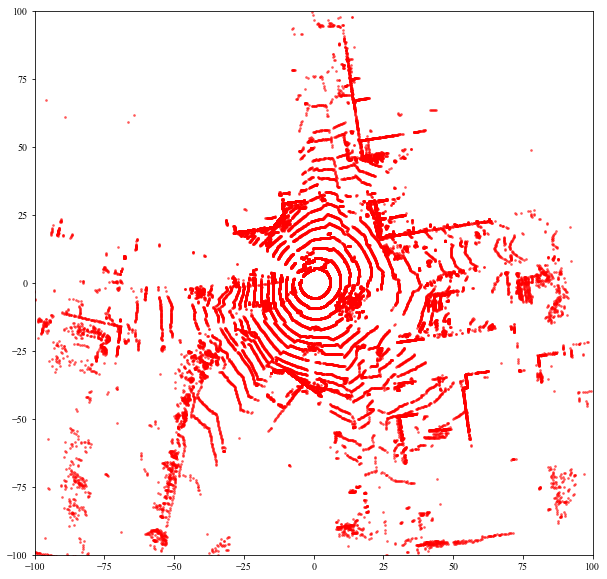

In [165]:
plt.figure(figsize=(10,10))
plt.plot(meas[400:,0,0,0],meas[400:,0,1,0], marker = 'x', markersize = 5, )
# plt.plot(post_seq[:,0,0,0],post_seq[:,0,1,0], marker = 'x', markersize = 5,c = 'r')
plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.5 , c = 'r')
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.show()

In [218]:
group_iter = data.groupby('ObjectID')
trajs = []
for i,g in group_iter:
    if len(g) < 20:
        continue
    dis = np.sqrt(np.sum(((np.array(g.iloc[0,[2,3]]) - np.array(g.iloc[-1,[2,3]]))**2)))
    if dis < 10:
        continue
    trajs.append(g)
post_data = pd.concat(trajs)

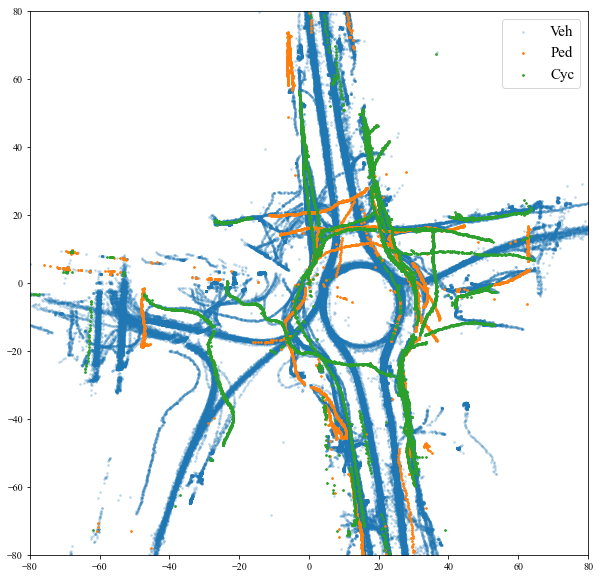

In [219]:
# post_data = pd.read_csv(r'D:\Test\test.csv') # path to result
plt.figure(figsize=(10,10))
plt.scatter(post_data.loc[post_data.Class == 1,'Coord_X'],post_data.loc[post_data.Class == 1,'Coord_Y'], s = 3, alpha = 0.2,label = 'Veh')
plt.scatter(post_data.loc[post_data.Class == 2,'Coord_X'],post_data.loc[post_data.Class == 2,'Coord_Y'], s = 3, label = 'Ped')
plt.scatter(post_data.loc[post_data.Class == 3,'Coord_X'],post_data.loc[post_data.Class == 3,'Coord_Y'], s = 3,label = 'Cyc')
plt.xlim(-80,80)
plt.ylim(-80,80)
plt.legend(fontsize = 15)
plt.show()

In [128]:
start_frame = 10
end_frame = 300

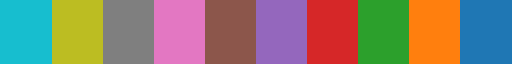

In [167]:
cm.tab10_r%10

In [165]:
np.array(cm.tab10_r(1)).reshape(1,-1)

array([[0.7372549 , 0.74117647, 0.13333333, 1.        ]])

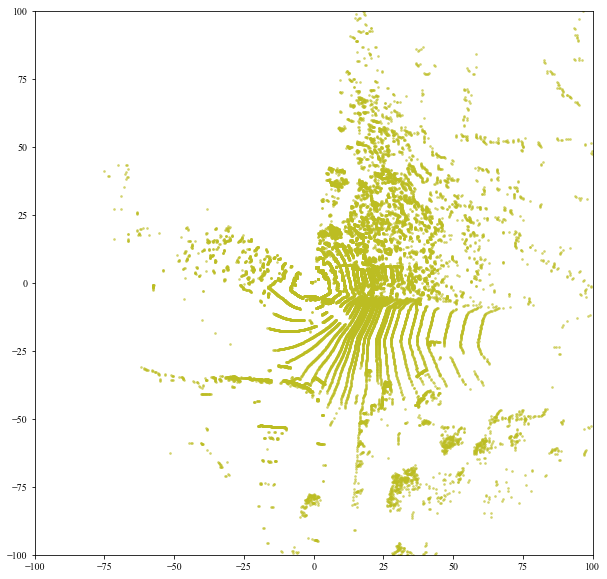

In [166]:
plt.figure(figsize=(10,10))
# plt.plot(meas[400:,0,0,0],meas[400:,0,1,0], marker = 'x', markersize = 5, )
# plt.plot(post_seq[:,0,0,0],post_seq[:,0,1,0], marker = 'x', markersize = 5,c = 'r')
plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.5 , c = np.array(cm.tab10_r(1)).reshape(1,-1))
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.show()

In [ ]:
from matplotlib import cm

In [133]:
start_frame = 0
end_frame = 310
pcap_path = r'D:\LiDAR_Data\MidTown\Roundabout\2022-1-19-14-30-0.pcap'
output_path = r''

In [ ]:
aggregated_map = []
end_frame = 3
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,_ = Frame
    aggregated_map.append(Td_map)
aggregated_map = np.array(aggregated_map)
pcd = get_pcd_colored(aggregated_map[-1],np.ones_like(aggregated_map[-1]))
points = np.asarray(pcd.points)

In [181]:
appearance_dic = {}
for f in range(start_frame,end_frame):
    coords = np.array(data.loc[data.FrameIndex == f].loc[:,['Coord_X','Coord_Y']])
    ObjID = np.array(data.loc[data.FrameIndex == f].loc[:,'ObjectID']).astype('int')
    classes = np.array(data.loc[data.FrameIndex == f].loc[:,'Class']).astype('int')
    for i,objid in enumerate(ObjID):
        if objid not in appearance_dic.keys():
            appearance_dic[objid] = [coords[i]]
        else:
            appearance_dic[objid].append(coords[i])
    plt.figure(figsize = (20,20))
    plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.5 , c = 'gray')
    for key in appearance_dic.keys():
        coord_key = np.array(appearance_dic[key])
        plt.plot(coord_key[:,0],coord_key[:,1], marker = 'x', markersize = 5,c = np.array(cm.tab10_r(key%10)).reshape(1,-1))
        clas = classes[ObjID == key]
        plt.annotate('{},{}'.format(key,clas),coord_key[-1],fontsize=20)
    
    plt.savefig(os.path.join(output_path,f))
    plt.close()